<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/MNIST_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

%matplotlib inline

In [86]:
epochs = 10
train_batch_size = 100
test_batch_size = 500
sample_size = min(train_batch_size, 9)

In [87]:
MNIST_train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
MNIST_test_data = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())

In [88]:
print(
    f"="*10 + " MNIST Train Data " + "="*10 + f"\n {MNIST_train_data}\n\n" + \
    f"="*10 + " MNIST Test Data " + "="*10 + f"\n {MNIST_test_data}"
)

========== MNIST Train Data ==========
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

========== MNIST Test Data ==========
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


Image Label: 5
Image Shape: torch.Size([1, 28, 28])


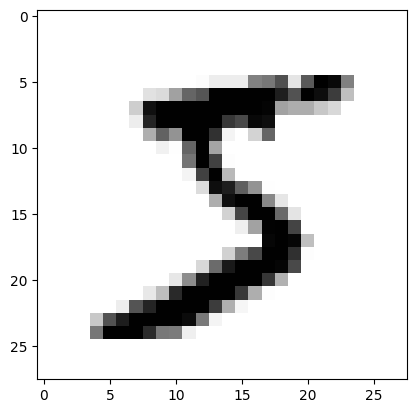

In [89]:
img, label = MNIST_train_data[0]
print(f"Image Label: {label}")
print(f"Image Shape: {img.shape}")
img = img.reshape(28,28)

plt.imshow(img, cmap="gist_yarg")
plt.show()

In [90]:
MNIST_train_data = DataLoader(MNIST_train_data, batch_size=train_batch_size, shuffle=True)
MNIST_test_data = DataLoader(MNIST_test_data, batch_size=test_batch_size, shuffle=True)

In [91]:
for img_batch, labels in MNIST_train_data:
  break

print(
    f"Image batch size: {img_batch.shape}\n" + \
    f"Label batch size: {labels.shape}"
)

Image batch size: torch.Size([100, 1, 28, 28])
Label batch size: torch.Size([100])


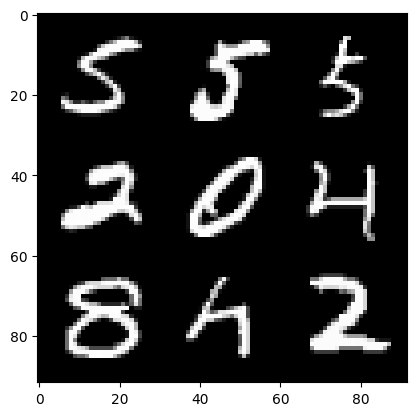

Img: 0, label: 5
Img: 1, label: 5
Img: 2, label: 5
Img: 3, label: 2
Img: 4, label: 0
Img: 5, label: 4
Img: 6, label: 8
Img: 7, label: 4
Img: 8, label: 2


In [92]:
img_sample = img_batch[:sample_size]

img_sample = make_grid(img_sample, nrow=3)
plt.imshow(np.transpose(img_sample.numpy(), (1,2,0)), cmap="gist_yarg") #CWH -> WHC (color, width, height)
plt.show()

print("\n".join([f"Img: {idx}, label: {label}" for idx, label in enumerate(labels[:sample_size])]))

In [93]:
class MultilayerPerceptron(nn.Module):

  def __init__(self, in_features, out_features, layers):

    super().__init__()

    self.model_layers = []

    input_layer_size = in_features

    for output_layer_size in layers:
      self.model_layers.append(
          nn.Linear(input_layer_size, output_layer_size)
      )

      input_layer_size = output_layer_size

    self.model_layers.append(
        nn.Linear(input_layer_size, out_features)
    )

    self.model_layers = nn.Sequential(*self.model_layers)

  def forward(self, features):
    layer_prediction = features

    for model_layer in self.model_layers:
      layer_prediction = func.relu(model_layer(layer_prediction))

    return func.log_softmax(layer_prediction)

model = MultilayerPerceptron(784, 10, [120, 84])

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [94]:
model

MultilayerPerceptron(
  (model_layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [95]:
train_losses = []
train_correct = []

test_losses = []
test_correct = []

for i in range(epochs):
  train_corr = 0
  test_corr = 0

  for batch_idx, (x_train, y_train) in enumerate(MNIST_train_data):

    y_pred = model(x_train.reshape(100, -1)) #.reshape(100, -1) === .view(100, -1)
    loss = criterion(y_pred, y_train)

    label_pred = torch.max(y_pred.data, 1)[1]
    batch_corr = (label_pred == y_train).sum()
    train_corr += batch_corr

    optim.zero_grad()
    loss.backward()
    optim.step()

    if batch_idx%100 == 0:
      train_acc = train_corr.item() / (batch_idx+1)
      print(f"Epoch: {i}, Batch idx: {batch_idx} obtained loss: {loss.item()}, accuracy: {train_acc}")

  train_losses.append(loss.detach().numpy())
  train_correct.append(train_corr)


  with torch.no_grad():
    for b, (x_test, y_test) in enumerate(MNIST_test_data):

      y_val = model(x_test.reshape(500, -1))
      label_pred = torch.max(y_val.data, 1)[1]
      test_corr += (label_pred == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


Epoch: 0, Batch idx: 0 obtained loss: 2.303109884262085, accuracy: 8.0


<ipython-input-93-3c125a9c2668>:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func.log_softmax(layer_prediction)


Epoch: 0, Batch idx: 100 obtained loss: 1.0163416862487793, accuracy: 56.613861386138616
Epoch: 0, Batch idx: 200 obtained loss: 0.9996939301490784, accuracy: 60.57213930348259
Epoch: 0, Batch idx: 300 obtained loss: 0.9806085228919983, accuracy: 62.199335548172755
Epoch: 0, Batch idx: 400 obtained loss: 0.8740456104278564, accuracy: 62.8927680798005
Epoch: 0, Batch idx: 500 obtained loss: 0.9393733143806458, accuracy: 63.51497005988024
Epoch: 1, Batch idx: 0 obtained loss: 0.7179230451583862, accuracy: 74.0
Epoch: 1, Batch idx: 100 obtained loss: 0.7604219317436218, accuracy: 75.78217821782178
Epoch: 1, Batch idx: 200 obtained loss: 0.5032997131347656, accuracy: 75.81094527363184
Epoch: 1, Batch idx: 300 obtained loss: 0.7629092931747437, accuracy: 76.18936877076412
Epoch: 1, Batch idx: 400 obtained loss: 0.659389317035675, accuracy: 76.25187032418953
Epoch: 1, Batch idx: 500 obtained loss: 0.6648068428039551, accuracy: 76.26746506986028
Epoch: 2, Batch idx: 0 obtained loss: 0.5415226

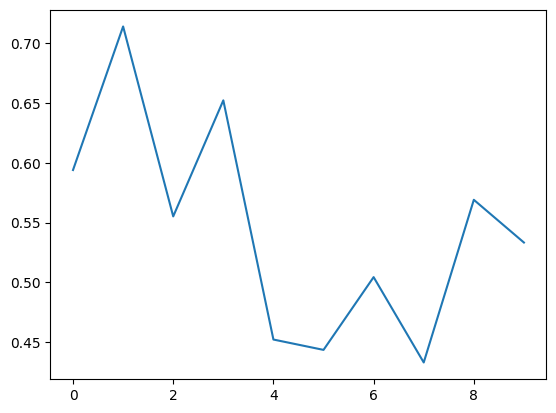

In [99]:
plt.plot(range(10), train_losses)
plt.show()